# COGS 108 - EDA Checkpoint

# Names

- Leica Shen
- Yuxuan Wu
- Eddie Ho
- Xuewen Yang

<a id='research_question'></a>
# Research Question

How has the COVID-19 pandemic impact global warming? Specifically, how do changes in greenhouse gas emissions from 2020 to 2022 resulting from pandemic-related lockdowns impact the rate of global temperature increase and sea level rise?

# Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 7)
import matplotlib.dates as mdates
import statsmodels.api as sm

In [2]:
temp_change = pd.read_csv('data/global_land_and_ocean_temp_anomalies.csv', skiprows=4)
temp_change.head()

,Year,Value
0,190001,-0.30
1,190002,-0.17
2,190003,-0.03
3,190004,-0.05
4,190005,-0.06


In [3]:
temp_change.shape

(1480, 2)

In [4]:
sea_level = pd.read_csv('data/Change_in_Mean_Sea_Levels.csv').drop(columns='ObjectId')
sea_level.head()

,Country,ISO2,ISO3,Indicator,Unit,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Measure,Date,Value
0,World,NaN,WLD,Change in mean sea level: Sea level: TOPEX.Pos...,Millimeters,National Oceanic and Atmospheric Administratio...,ECCL,Change in Mean Sea Level,"Environment, Climate Change, Climate Indicator...",Andaman Sea,D12/17/1992,-10.34
1,World,NaN,WLD,Change in mean sea level: Sea level: TOPEX.Pos...,Millimeters,National Oceanic and Atmospheric Administratio...,ECCL,Change in Mean Sea Level,"Environment, Climate Change, Climate Indicator...",Arabian Sea,D12/17/1992,-18.46
2,World,NaN,WLD,Change in mean sea level: Sea level: TOPEX.Pos...,Millimeters,National Oceanic and Atmospheric Administratio...,ECCL,Change in Mean Sea Level,"Environment, Climate Change, Climate Indicator...",Atlantic Ocean,D12/17/1992,-15.41
3,World,NaN,WLD,Change in mean sea level: Sea level: TOPEX.Pos...,Millimeters,National Oceanic and Atmospheric Administratio...,ECCL,Change in Mean Sea Level,"Environment, Climate Change, Climate Indicator...",Baltic Sea,D12/17/1992,196.85
4,World,NaN,WLD,Change in mean sea level: Sea level: TOPEX.Pos...,Millimeters,National Oceanic and Atmospheric Administratio...,ECCL,Change in Mean Sea Level,"Environment, Climate Change, Climate Indicator...",Bay Bengal,D12/17/1992,3.27


In [5]:
sea_level.shape

(35604, 12)

In [6]:
CO2_Concentrations = pd.read_csv('data/Atmospheric_CO2_Concentrations.csv').drop(columns='ObjectId')
CO2_Concentrations.head()

,Country,ISO2,ISO3,Indicator,Unit,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Date,Value
0,World,NaN,WLD,Monthly Atmospheric Carbon Dioxide Concentrations,Parts Per Million,"Dr. Pieter Tans, National Oceanic and Atmosphe...",ECCA,Atmospheric Carbon Dioxide Concentrations,"Environment, Climate Change, Climate Indicator...",1958M03,315.70
1,World,NaN,WLD,Monthly Atmospheric Carbon Dioxide Concentrations,Parts Per Million,"Dr. Pieter Tans, National Oceanic and Atmosphe...",ECCA,Atmospheric Carbon Dioxide Concentrations,"Environment, Climate Change, Climate Indicator...",1958M04,317.45
2,World,NaN,WLD,Monthly Atmospheric Carbon Dioxide Concentrations,Parts Per Million,"Dr. Pieter Tans, National Oceanic and Atmosphe...",ECCA,Atmospheric Carbon Dioxide Concentrations,"Environment, Climate Change, Climate Indicator...",1958M05,317.51
3,World,NaN,WLD,Monthly Atmospheric Carbon Dioxide Concentrations,Parts Per Million,"Dr. Pieter Tans, National Oceanic and Atmosphe...",ECCA,Atmospheric Carbon Dioxide Concentrations,"Environment, Climate Change, Climate Indicator...",1958M06,317.24
4,World,NaN,WLD,Monthly Atmospheric Carbon Dioxide Concentrations,Parts Per Million,"Dr. Pieter Tans, National Oceanic and Atmosphe...",ECCA,Atmospheric Carbon Dioxide Concentrations,"Environment, Climate Change, Climate Indicator...",1958M07,315.86


In [7]:
CO2_Concentrations.shape

(1548, 11)

# Data Cleaning

Describe your data cleaning steps here.

### sea_level table

1. Extract `Year` and `Month` of each observation from the `Date` column and convert them into `int` data type. \
    The `Year` and `Month` columns from the above step will be combined with only the `Measure` and `Value` columns from the `sea_level` table. \
    The resulting merged data will be stored in the `sea_level_cleaned` table.
    

In [8]:
sea_level_cleaned = pd.merge(sea_level[['Measure', 'Value']], sea_level['Date'].str.split('D', expand=True)[1].str.split('/', expand=True)[[0,2]].rename(columns={0:'Month', 2:'Year'}), left_index=True, right_index=True)
sea_level_cleaned['Year'] = sea_level_cleaned['Year'].astype(int)
sea_level_cleaned['Month'] = sea_level_cleaned['Month'].astype(int)
sea_level_cleaned.head()

,Measure,Value,Month,Year
0,Andaman Sea,-10.34,12,1992
1,Arabian Sea,-18.46,12,1992
2,Atlantic Ocean,-15.41,12,1992
3,Baltic Sea,196.85,12,1992
4,Bay Bengal,3.27,12,1992


2. Group by `Year` and `Month`, get the mean of `Value` of the `sea_level_cleaned` table. \
    The resulting table will be stored in the `mean_sea_level_by_month` table. \
    

In [9]:
mean_sea_level_by_month = sea_level_cleaned.groupby(['Year', 'Month'])[['Value']].mean().reset_index().sort_values(['Year', 'Month']) 
mean_sea_level_by_month.head()

,Year,Month,Value
0,1992,12,4.265600
1,1993,1,-14.385067
2,1993,2,-31.307733
3,1993,3,-39.215733
4,1993,4,-49.520400


3. Group by `Measure` and `Year`, get the mean value of `Value` of the `sea_level_cleaned` table. \
    The resulting table will be stored in the `mean_sea_level_by_sea` table.

In [10]:
mean_sea_level_by_sea = sea_level_cleaned.groupby(['Measure', 'Year'])[['Value']].mean().reset_index().sort_values(['Measure', 'Year']) 
mean_sea_level_by_sea.head()

,Measure,Year,Value
0,Adriatic Sea,1992,-21.360000
1,Adriatic Sea,1993,-47.668824
2,Adriatic Sea,1994,-23.842353
3,Adriatic Sea,1995,-19.478750
4,Adriatic Sea,1996,2.120303


### temp_change table

1. Create `temp_change_cleaned` data frame to store the cleaned data. 
2. Extract `Year` column from the original `temp_change` data frame, convert those dates to strings. 
3. Use string slicing to retrieve `Year` and `Month` from the dates in the uncleaned data frame, converts them to int, and then assign them to the corresponding `Year` and `Month` column of the cleaned `temp_change_cleaned` data frame. 
4. Sort the cleaned data in `temp_change_cleaned` by the `Year` and `Month` of the data. 

In [11]:
temp_change_cleaned = temp_change.copy()
time = temp_change['Year'].astype(str)
temp_change_cleaned['Year'] = time.str[:4].astype(int)
temp_change_cleaned['Month'] = time.str[4:].astype(int)
temp_change_cleaned = temp_change_cleaned.groupby(['Year', 'Month']).mean().reset_index().sort_values(['Year', 'Month']) 
temp_change_cleaned.head()

,Year,Month,Value
0,1900,1,-0.30
1,1900,2,-0.17
2,1900,3,-0.03
3,1900,4,-0.05
4,1900,5,-0.06


### CO2_Concentrations table

1. Create `CO2_cleaned` dataframe to store the cleaned data.
2. Extract `Date` column from the original `CO2_cleaned` dataframe, use string slicing to retrieve `Year` and `Month`, and then assign them to the corresponding `Year` and `Month` column of the cleaned `CO2_cleaned` dataframe.
3. Drop rows where `Unit` = `Percent` as we won't be performing on those records.
4. Sort the cleaned data in `CO2_cleaned` by `Year` and `Month` of the data.

In [12]:
# Extract the year and month from the date column
CO2_cleaned = (
    CO2_Concentrations
    .assign(Year=CO2_Concentrations['Date'].str.split('M').map(lambda x: x[0]).astype(int),
            Month=CO2_Concentrations['Date'].str.split('M').map(lambda x: x[1]).astype(int))
    .drop(columns=['Date'])
)

# Remove the percent values
CO2_cleaned = CO2_cleaned[CO2_cleaned['Unit'] != 'Percent']

# Sort the values by year and month
CO2_cleaned = (
    CO2_cleaned
    .sort_values(['Year', 'Month'])
    .get(['Year', 'Month', 'Value'])
)

CO2_cleaned

,Year,Month,Value
0,1958,3,315.70
1,1958,4,317.45
2,1958,5,317.51
3,1958,6,317.24
4,1958,7,315.86
...,...,...,...
1538,2022,10,415.78
1540,2022,11,417.51
1542,2022,12,418.95
1544,2023,1,419.47


### Merging data sets

Our plan for combining these datasets: 
1. Merge the first dataset Temp Anomalies with the second dataset Change in Mean Sea Levels on the Year / Month columns.

2. Merge this combined dataset with the third dataset Atmospheric CO2 Concentrations again on the Year / Month columns.

In [13]:
# Merge the two dataframes
mean_sea_level_by_month = mean_sea_level_by_month.rename(columns={'Value': 'Sea_Level'})
temp_change_cleaned = temp_change_cleaned.rename(columns={'Value': 'Temp_Anomaly'})
temp_sealevel_df = pd.merge(mean_sea_level_by_month, temp_change_cleaned, how='inner', on=['Year', 'Month'])
temp_sealevel_df.head()

,Year,Month,Sea_Level,Temp_Anomaly
0,1992,12,4.265600,0.22
1,1993,1,-14.385067,0.34
2,1993,2,-31.307733,0.39
3,1993,3,-39.215733,0.38
4,1993,4,-49.520400,0.36


The resulting merged data frame will have columns of `Year`, `Month`, `sea-level_value`, `temp_value`, `CO2_value`：

In [14]:
CO2_cleaned = CO2_cleaned.rename(columns={'Value': 'CO2_Concentration'})
merged_df = pd.merge(temp_sealevel_df, CO2_cleaned, how='inner', on=['Year', 'Month'])
merged_df['Year_Month'] = pd.to_datetime(merged_df['Year'].astype(str)+ '-' + merged_df['Month'].astype(str))
merged_df.head()

,Year,Month,Sea_Level,Temp_Anomaly,CO2_Concentration,Year_Month
0,1992,12,4.265600,0.22,355.68,1992-12-01
1,1993,1,-14.385067,0.34,357.10,1993-01-01
2,1993,2,-31.307733,0.39,357.42,1993-02-01
3,1993,3,-39.215733,0.38,358.59,1993-03-01
4,1993,4,-49.520400,0.36,359.39,1993-04-01


# Data Analysis & Results (EDA)

### $CO_2$ Concentration

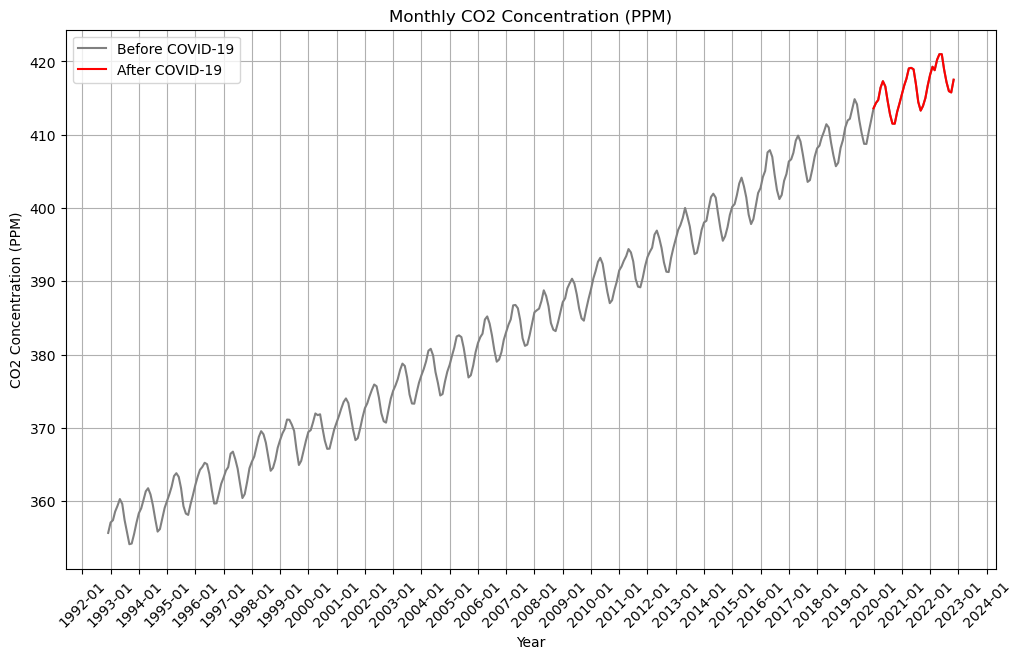

In [15]:
# Create a boolean mask for dates after 2019-12-01
mask = merged_df['Year_Month'] > pd.to_datetime('2019-12-01')

plt.plot(merged_df['Year_Month'], merged_df['CO2_Concentration'], label='Before COVID-19', color='gray')

# Use boolean mask to highlight data after Covid-19 outbreak
plt.plot(merged_df['Year_Month'][mask], merged_df['CO2_Concentration'][mask], label='After COVID-19', color='red')

plt.title('Monthly CO2 Concentration (PPM)')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (PPM)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

This line graph illustrates the monthly $CO_2$ concentration in parts per million (ppm) over time on monthly basis. 

Notably, the graph reveals a distinct pattern characterized by a periodic Z-shape staircase trend.

At the beginning of each year, there is a noticeable increase in $CO_2$ concentration, represented by an upward trend in the graph. This upward trend is followed by a downward trend in the middle of the year and after that there is another upward trend towards the end of the year.

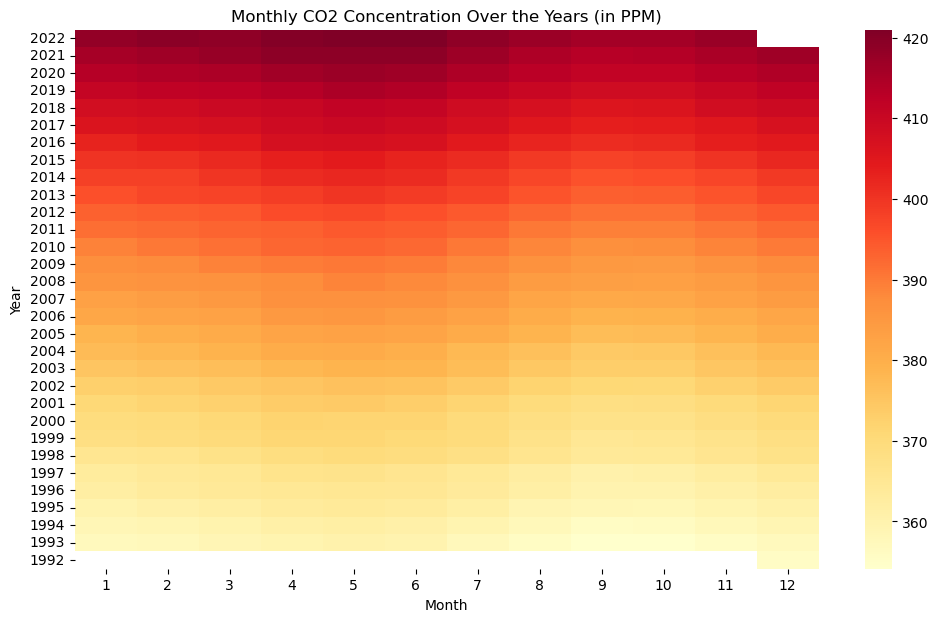

In [16]:
# Create a new DataFrame with years as index, months as columns, and CO2 concentration as values
heatmap_data = merged_df.pivot(index='Year', columns='Month', values='CO2_Concentration')
heatmap_data = heatmap_data.sort_index(axis=0, ascending=False)

# Draw the heatmap for monthly CO2 concentration
sns.heatmap(heatmap_data, cmap='YlOrRd')

plt.title('Monthly CO2 Concentration Over the Years (in PPM)')
plt.xlabel('Month')
plt.ylabel('Year')

plt.show()

The heatmap illustrates the $CO_2$ concentration in parts per million (ppm) for each month of the years from 1992 to the present. The x-axis represents the months, while the y-axis shows the years in descending order, so the top of the graph represents the most recent data, while the bottom represents the earlier years. Also note that the color intensity signifies the $CO_2$ concentration. Darker shades indicate higher CO2 concentration and lighter ones represent lower concentrations.

The heatmap reveals a persistent trend of increasing $CO_2$ concentration over the years. Notably, the color intensity progressively darkens towards the top of the graph, which signifies a rising trend in $CO_2$ concentration. We observe that despite the global pandemic and consequent reduction in human activities, the $CO_2$ concentration does not show any sign of decrease. This observation is consistent with the findings of the graphs above, all of them are showing a steady increase in $CO_2$ concentration over the years. 

Here are two possible explanations for this observation:
1. Momentum of $CO_2$ emissions: The COVID-19 pandemic led to a reduction in human activities and consequently, $CO_2$ emissions. However, this reduction didn't mean an absolute halt. 
2. Persistence of $CO_2$ in the atmosphere: $CO_2$ persists in the atmosphere for a long time once it's released. Even with a significant short-term reduction in emissions, the concentration of $CO_2$ doesn't decrease quickly. 

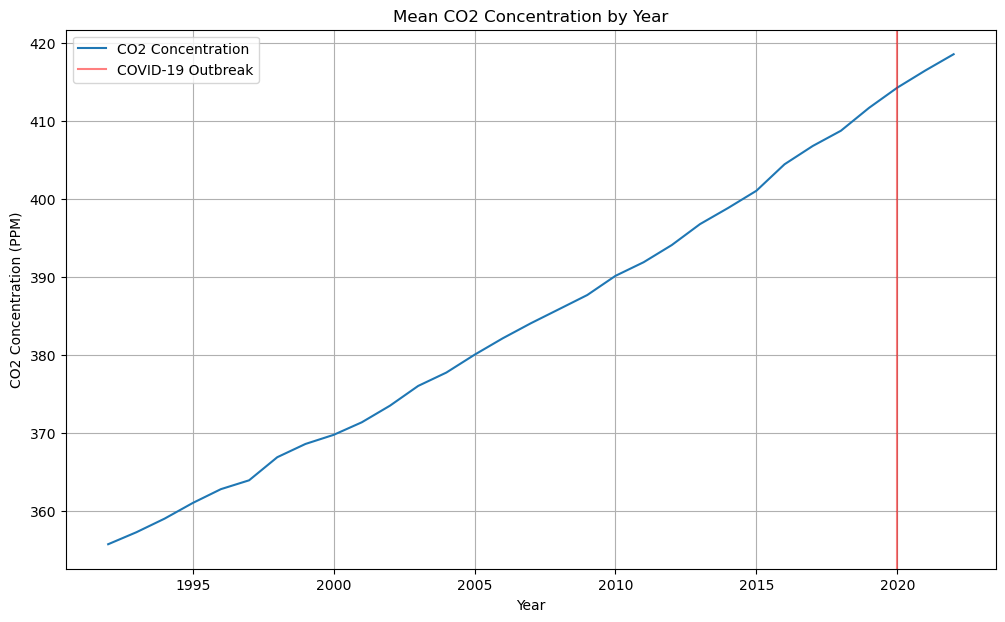

In [17]:
merged_df.groupby('Year')['CO2_Concentration'].mean().plot(label='CO2 Concentration')

plt.xlabel('Year')
plt.ylabel('CO2 Concentration (PPM)')
plt.title('Mean CO2 Concentration by Year')
plt.axvline(x=2020, color='red', alpha=0.5, label='COVID-19 Outbreak')
plt.legend()

plt.grid(True)
plt.show()

The line plot shows that $CO_2$ emissions have been increasing over the years. This indicates that despite the pandemic (2019-2022), there hasn't been a significant decrease in $CO_2$ emissions. This observation contradicts our initial anticipation of a decrease in emissions during the pandemic period.

Thus, instead of analyzing the impact of the **decrease** of $CO_2$ concentration to the rate of global temperature increase and sea level rise, we will analyze the impact of **overall** $CO_2$ concentration to the rate of global temperature increase and sea level rise. 

Starting by checking their correlations.

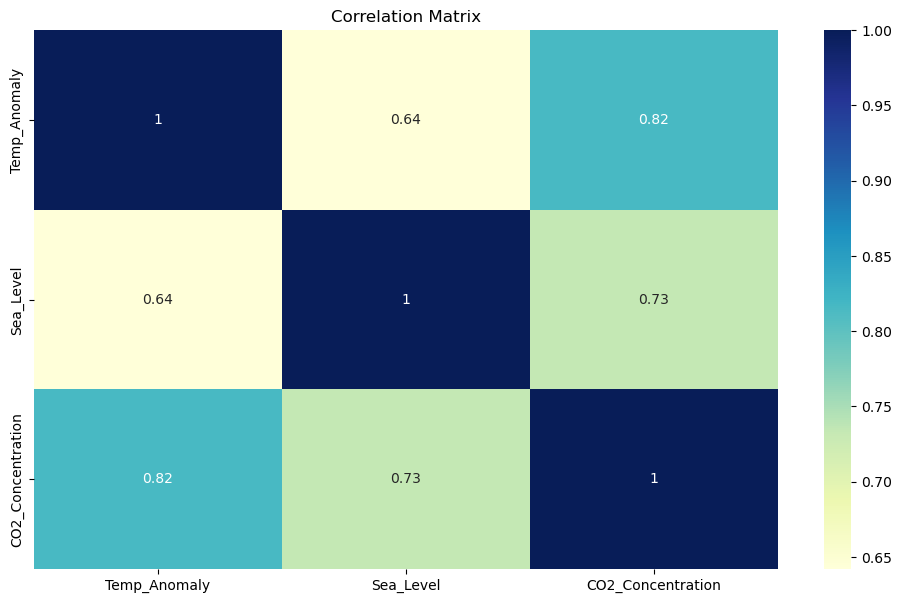

In [18]:
# Correlation analysis
correlation_matrix = merged_df[['Temp_Anomaly', 'Sea_Level', 'CO2_Concentration']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

The correlation matrix reveals that there is a strong positive correlation between $CO_2$ concentration and temperature anomalies, with a correlation coefficient of 0.82. This indicates a significant and positive relationship between the two variables. Similarly, there is a relatively strong positive correlation of 0.73 between $CO_2$ concentration and the average change in sea level.

However, it's crucial to note that correlation alone does not imply causation. While the high correlation coefficients suggest a relationship between the variables, further analysis is required to establish any causal connections or identify underlying factors. Thus, we are going to do more analysis below. 

### Temperature Anomly

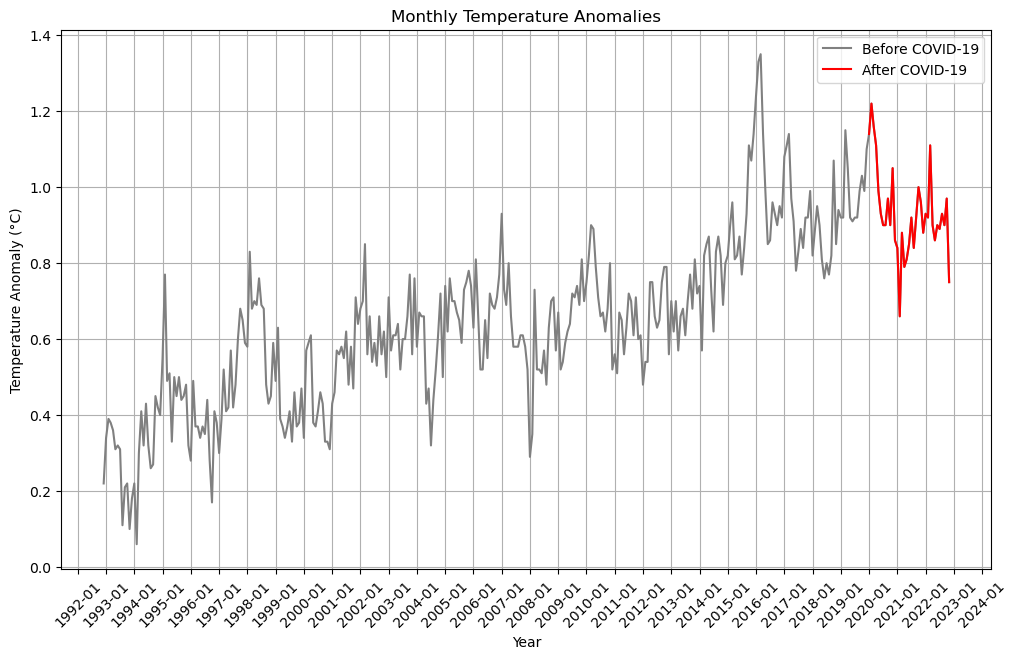

In [19]:
# Temperature Anomly per Year
# Create a boolean mask for dates after 2019-12-01
mask = merged_df['Year_Month'] > pd.to_datetime('2019-12-01')

# Plot all data with a lighter color
plt.plot(merged_df['Year_Month'], merged_df['Temp_Anomaly'], label='Before COVID-19', color='gray')

# Use boolean mask to plot data after 2019-12-01 with a different color
plt.plot(merged_df['Year_Month'][mask], merged_df['Temp_Anomaly'][mask], label='After COVID-19', color='red')

plt.title('Monthly Temperature Anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

The monthly temperature anomalies plot indicates a general upward trend in temperature anomalies. Prior to the COVID-19 outbreak, the gray line representing temperature anomalies exhibited fluctuations throughout the year but showed a consistent upward trajectory. However, after the outbreak, there was a noticeable change in the trend. The temperature anomalies in the post-COVID-19 period displayed a slower rate of increase and a more flattened pattern. Based on these observations, it suggests that the COVID-19 pandemic might have had an impact on temperature anomalies.

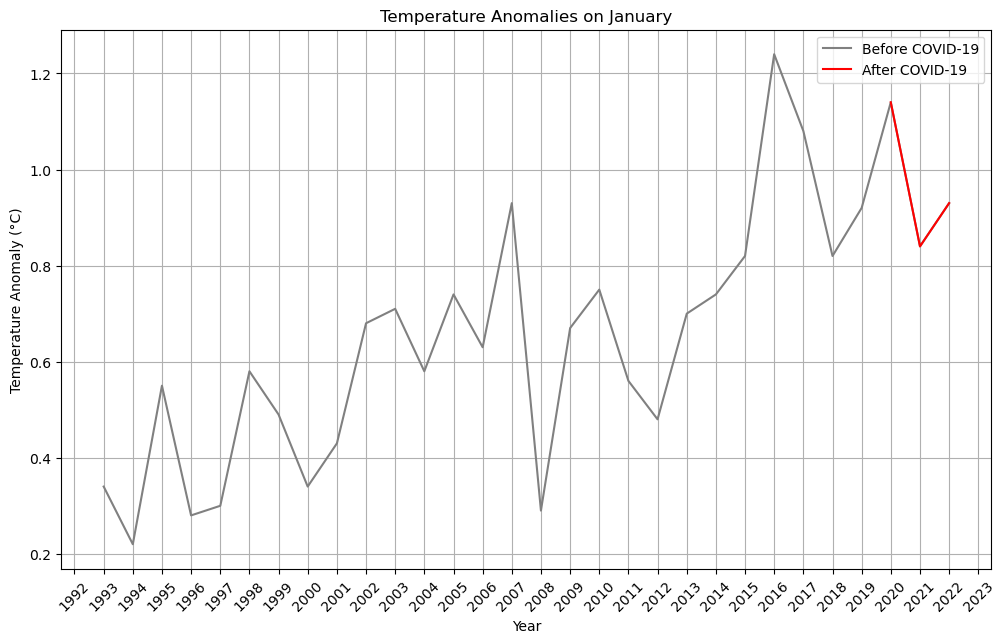

In [20]:
df = merged_df[merged_df['Month'] == 1]

mask = (df['Year_Month'] > pd.to_datetime('2019-12-01')
        ) & (df['Year_Month'] < pd.to_datetime('2022-12-01'))

# Plot all data with a lighter color
plt.plot(df['Year_Month'], df['Temp_Anomaly'],
         label='Before COVID-19', color='gray')

# Use boolean mask to plot data after 2019-12-01 with a different color
plt.plot(df['Year_Month'][mask], df['Temp_Anomaly']
         [mask], label='After COVID-19', color='red')

plt.title('Temperature Anomalies on January')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

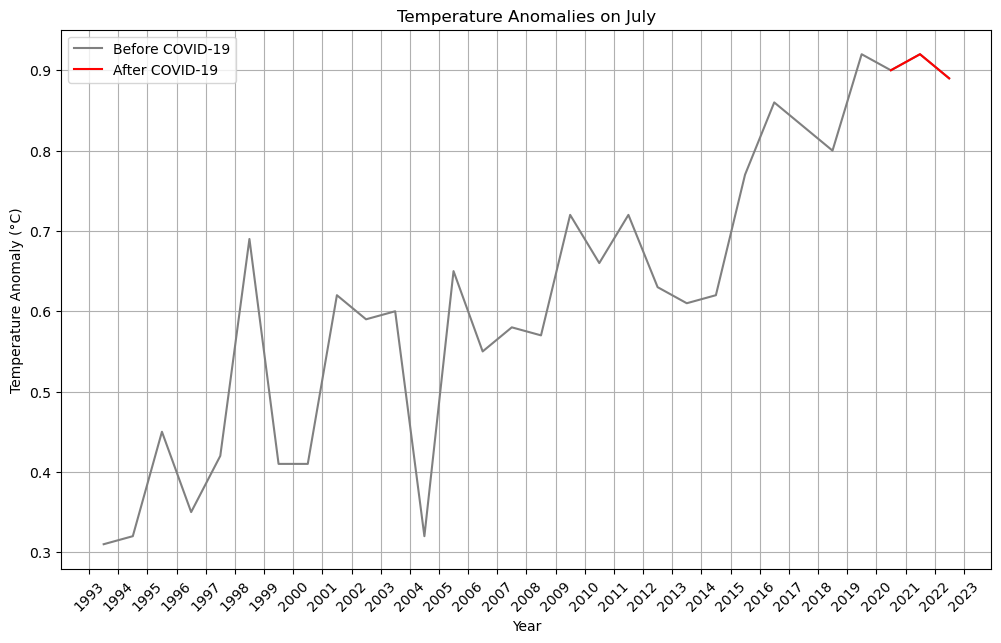

In [21]:
df = merged_df[merged_df['Month'] == 7]

mask = (df['Year_Month'] > pd.to_datetime('2019-12-01')) & (df['Year_Month'] < pd.to_datetime('2022-12-01'))

# Plot all data with a lighter color
plt.plot(df['Year_Month'], df['Temp_Anomaly'], label='Before COVID-19', color='gray')

# Use boolean mask to plot data after 2019-12-01 with a different color
plt.plot(df['Year_Month'][mask], df['Temp_Anomaly'][mask], label='After COVID-19', color='red')

plt.title('Temperature Anomalies on July')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

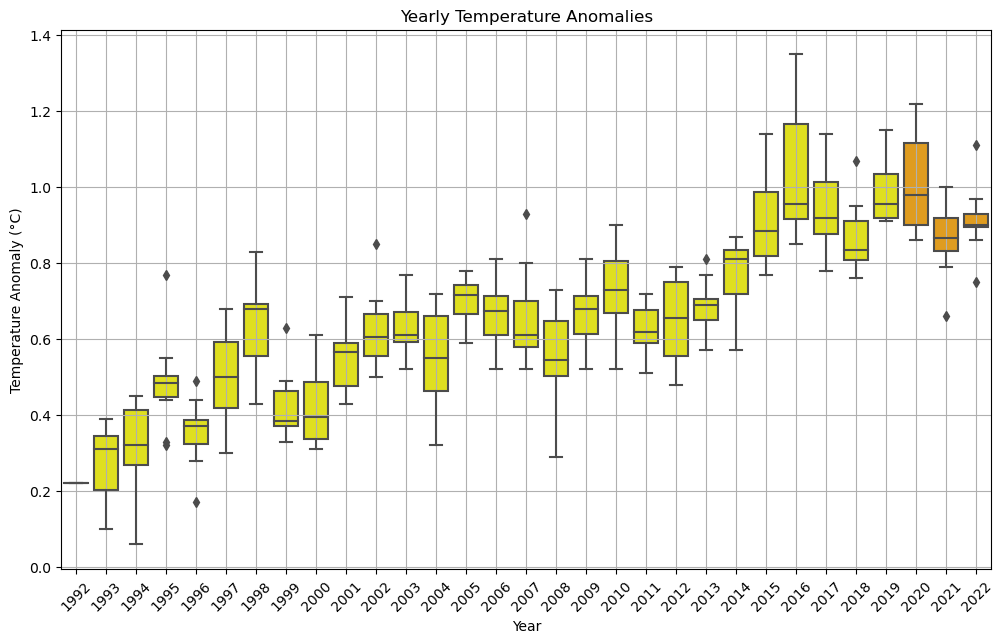

In [22]:
# Create a palette that maps each year to a color based on whether it's before or after 2020
palette = {year: 'orange' if year >= 2020 else 'yellow' for year in merged_df['Year'].unique()}

# Create a boxplot with the custom color palette
sns.boxplot(x="Year", y="Temp_Anomaly", data=merged_df, palette=palette)

plt.title('Yearly Temperature Anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

The box plot provides insights into the distribution of temperature anomalies across different years. Prior to the COVID-19 period, the average temperature anomalies show a consistent increasing trend with some minor fluctuations. This suggests an overall rise in temperature anomalies over time.

In contrast, the temperature anomalies observed after the COVID-19 period exhibit greater stability and a flattened pattern. This indicates a potential impact of COVID-19 on temperature anomalies, leading to a more leveled trend.

Overall, the box plot highlights the contrasting patterns in temperature anomalies before and after the COVID-19 period, suggesting a potential influence of the pandemic on temperature trends.

### Hypothesis Test

In [23]:
# Extracting the relevant columns
temp_anomaly_data = merged_df[['Year', 'Temp_Anomaly']]

# Perform linear regression
# Adding a constant term for the intercept
X = sm.add_constant(temp_anomaly_data['Year'])
y = temp_anomaly_data['Temp_Anomaly']
model = sm.OLS(y, X)
results = model.fit()

# Extract slope and p-value
slope = results.params['Year']
p_value = results.pvalues['Year']

# Print regression results summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Temp_Anomaly   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     736.4
Date:                Wed, 31 May 2023   Prob (F-statistic):           6.98e-89
Time:                        15:05:37   Log-Likelihood:                 221.61
No. Observations:                 360   AIC:                            -439.2
Df Residuals:                     358   BIC:                            -431.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -42.8017      1.602    -26.721      0.0

The OLS regression results provide information about the relationship between the Year predictor variable and the Temp_Anomaly dependent variable. Here's how we interpret the important statistics:

1. Coefficients: The coefficient values represent the estimated effect of the `Year` variable on the `Temp_Anomaly`. In this case, the coefficient for `Year` is **0.0217**. This means that, on average, for each unit increase in the `Year` variable, the `Temp_Anomaly` is expected to increase by **0.0217** (°C).
1. P-values: The `p-values` associated with the coefficients indicate the statistical significance of the relationship. In this case, both the constant term (const) and the `Year` variable have `p-values` less than the typical significance level of **0.05**. This suggests that both variables have a significant impact on the `Temp_Anomaly`.

In summary, based on the results, there is a significant positive relationship between the `Year` and `Temp_Anomaly` variables. The increase in the `Year` variable is associated with an increase in the `Temp_Anomaly` variable.

In [24]:
# Hypothesis testing
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. Temperture anomaly is rising.")
else:
    print("Fail to reject the null hypothesis. No significant evidence of temperture anomaly rise.")

Reject the null hypothesis. Temperture anomaly is rising.


### Sea Level

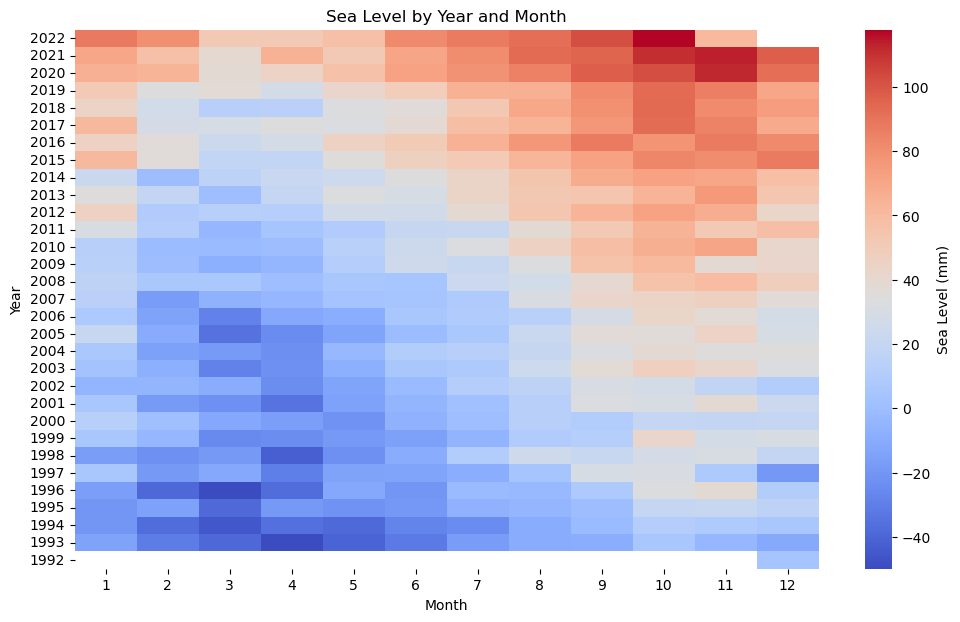

In [25]:
heatmap_data = merged_df.pivot_table(values='Sea_Level', index='Year', columns='Month').sort_index(ascending=False)
sns.heatmap(data=heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Sea Level (mm)'})
plt.title('Sea Level by Year and Month')
plt.show()

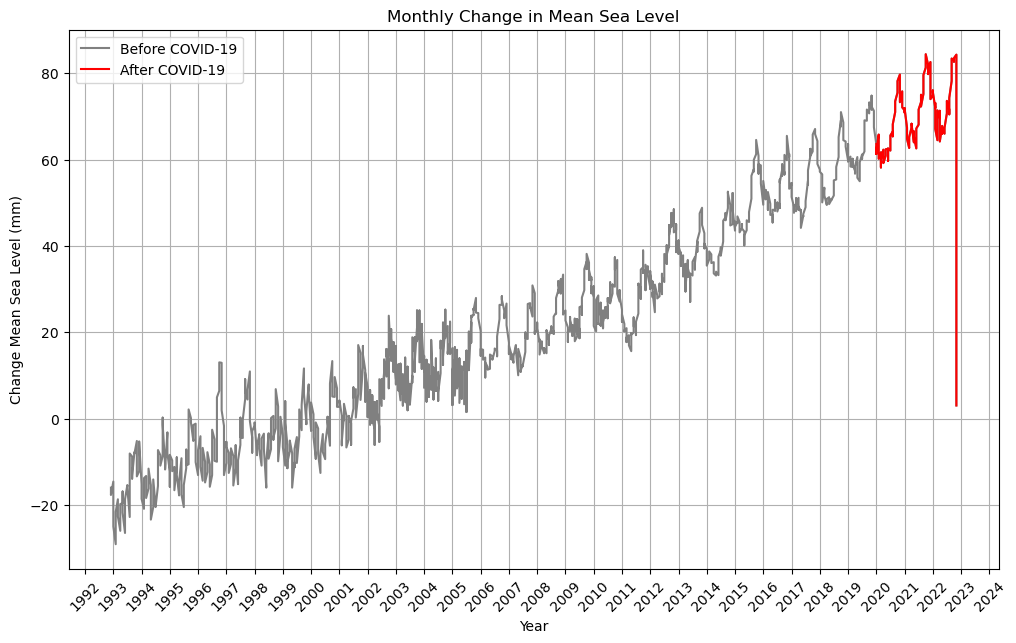

In [26]:
sea_level_cleaned['Year_Month'] = pd.to_datetime(sea_level_cleaned['Year'].astype(
    str) + '-' + sea_level_cleaned['Month'].astype(str))
sea_level_world = sea_level_cleaned[sea_level_cleaned['Measure'] == 'World']

# Create a boolean mask for dates after 2019-12-01
mask = sea_level_world['Year_Month'] > pd.to_datetime('2019-12-01')

# Plot all data with a lighter color
plt.plot(sea_level_world['Year_Month'], sea_level_world['Value'],
         label='Before COVID-19', color='gray')

# Use boolean mask to plot data after 2019-12-01 with a different color
plt.plot(sea_level_world.loc[mask, 'Year_Month'],
         sea_level_world.loc[mask, 'Value'], label='After COVID-19', color='red')

plt.title('Monthly Change in Mean Sea Level')
plt.xlabel('Year')
plt.ylabel('Change Mean Sea Level (mm)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

The line plot above illustrates the monthly changes in the mean sea level worldwide from December 1992 to November 2022. It specifically focuses on the post-COVID-19 period to analyze the potential impact of the pandemic on sea level fluctuations.

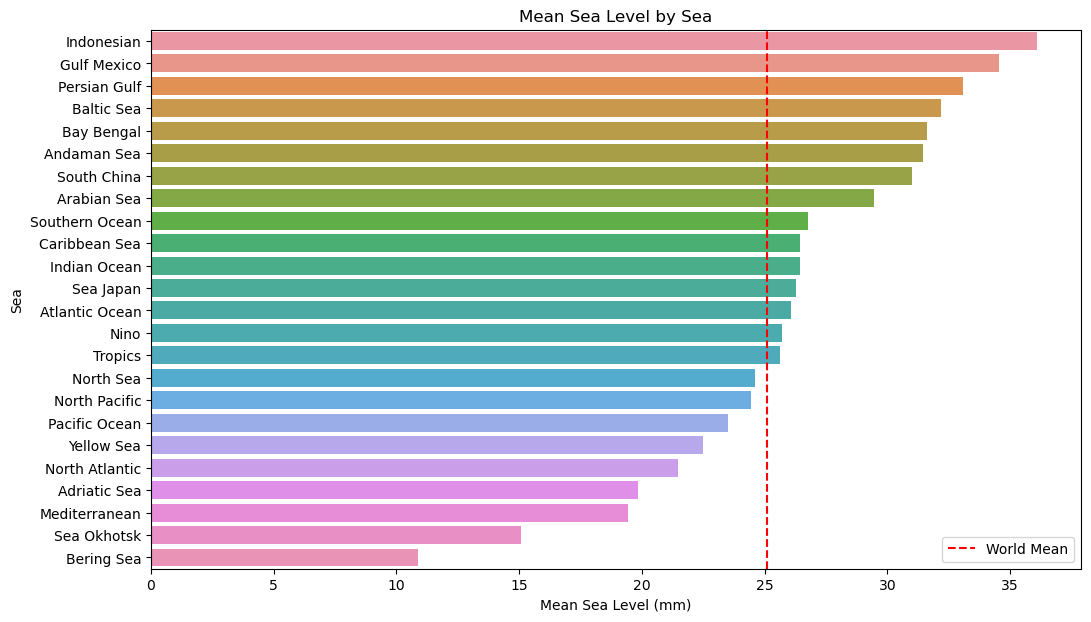

In [27]:
sea_level_by_year = (sea_level_cleaned
                     [sea_level_cleaned['Measure'] != 'World']
                     .groupby('Measure')
                     [['Value']]
                     .mean()
                     .reset_index())
mean_sea_level_world = (sea_level_cleaned
                        .loc[sea_level_cleaned['Measure'] == 'World', 'Value']
                        .mean(numeric_only=None))

sns.barplot(x='Value', y='Measure',
            data=sea_level_by_year.sort_values('Value', ascending=False))
plt.axvline(x=mean_sea_level_world, color='red',
            linestyle='--', label='World Mean')

plt.title('Mean Sea Level by Sea')
plt.xlabel('Mean Sea Level (mm)')
plt.ylabel('Sea')
plt.legend()

plt.show()

The bar chart above illustrates the average monthly change in sea level across different oceans from December 1992 to November 2022, with a comparison to the `World Mean` measure.

## Hypothesis Test

To perform a hypothesis test on whether the sea level is rising or not based on the given table, we decided use a statistical test; linear regression analysis.

- **Null Hypothesis (H0)**: The sea level is not rising (slope of the linear regression line is zero).
- **Alternative Hypothesis (HA)**: The sea level is rising (slope of the linear regression line is non-zero).

In [28]:
# Extracting the relevant columns
sea_level_data = sea_level_world[['Year', 'Value']]

# Perform linear regression
# Adding a constant term for the intercept
X = sm.add_constant(sea_level_data['Year'])
y = sea_level_data['Value']
model = sm.OLS(y, X)
results = model.fit()

# Extract slope and p-value
slope = results.params['Year']
p_value = results.pvalues['Year']

# Print regression results summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 1.502e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        15:05:38   Log-Likelihood:                -4854.0
No. Observations:                1426   AIC:                             9712.
Df Residuals:                    1424   BIC:                             9723.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6072.3960     49.756   -122.043      0.0

Based on the OLS regression results, the coefficient for the `Year` variable is **3.0367**, and it is statistically significant (`p-value` < **0.05**). This indicates that there is a positive relationship between the `Year` variable (representing time) and the `Value` variable (sea level).

The `R-squared value` of **0.913** suggests that the model explains approximately **91.3%** of the variance in the sea level data.

Therefore, we can conclude that there is strong evidence to support the hypothesis that the sea level is rising over time based on the analysis conducted. The coefficient estimate of **3.0367** implies that, on average, the sea level increases by approximately **3.0367** units per year.

In [29]:
# Hypothesis testing
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. Sea level is rising.")
else:
    print("Fail to reject the null hypothesis. No significant evidence of sea level rise.")

Reject the null hypothesis. Sea level is rising.
